In [53]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import geopandas as gpd
from shapely.geometry import Polygon
import networkx as nx


## Geographical Heat Map

### Importing the number of business applications

Taking our existing data of business applications and importing as a DataFrame

In [25]:
df_biz = pd.read_csv("data/biz_apps_new.csv")
df_biz = df_biz.rename(columns={"State":"STATE"}).round(2)
df_biz.head()

,Name,STATE,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Alabama,AL,31078,33918,33701,32222,29221,29916,28994,29694,29331,29574,31506,34286,36760,41948,41478,58557,75443,70750
1,Alaska,AK,4730,5229,5138,4979,4396,4661,5083,5210,5383,5447,5901,6358,7263,9238,8118,8063,8063,8456
2,Arizona,AZ,56547,63067,64673,62972,58279,57926,57837,55305,55516,56401,57176,61448,67833,73424,76539,89957,113142,115080
3,Arkansas,AR,19133,20400,19630,18707,17927,17843,17939,17812,17551,18445,19033,20445,23135,25678,25473,32314,41599,37562
4,California,CA,271636,286652,286737,271606,249246,256436,270057,268103,278014,293443,303657,312636,326592,364807,364924,438554,519236,485954


### Importing the geographical file for the US states

Using geopandas, we create a dataframe of the US States with their name, longitude, latitude and geometry

In [26]:
shapefile = 's_08mr23/s_08mr23.shp'
gdf = gpd.read_file(shapefile)
gdf.head()

,STATE,NAME,FIPS,LON,LAT,geometry
0,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ..."
1,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499..."
2,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-168.14924 -14.53377, -168.148..."
3,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.49090 37.00361, -110.48750 37.0..."
4,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263..."


In [27]:
#drop Puerto rico, Fed States of Micronesia, American Samoa, US Virgin Islands, Guam, Commonwealth of the northern mariana islands from file
gdf = gdf.drop(index=[2,37,44,52,54,55,56,57])
gdf = gdf.reset_index(drop=True)

In [28]:
len(gdf) #it is the same as len(df)

51

<Axes: >

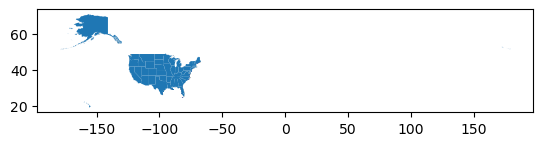

In [29]:
gdf.plot()

We see the issue here - due to Alaska and Hawaii, we are unable to get a closer look at the US. We will remove these and add them separately to our final graph

### Clipping Alaska and Hawaii
Creating a dataset that will only include the business applications from 2022 as a column

In [30]:
df_diff = df_biz[['STATE','2005','2022']].copy()
df_diff = df_diff.rename(columns={"2005":"BA_2005", "2022":"BA_2022"})
df_diff.head()

,STATE,BA_2005,BA_2022
0,AL,31078,70750
1,AK,4730,8456
2,AZ,56547,115080
3,AR,19133,37562
4,CA,271636,485954


We are going to clip Hawaii and Alaska and add them separately. 

<Axes: >

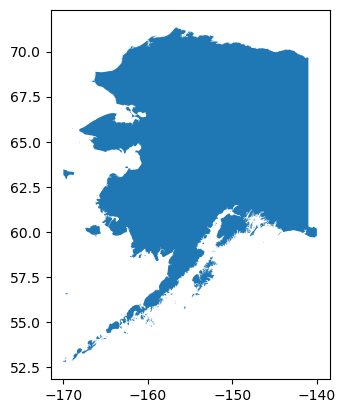

In [31]:
alaska_gdf = gdf[gdf.STATE=='AK']
alaska_gdf = alaska_gdf.merge(df_diff, on="STATE")
#clipping some of the western islands to make it fit better
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = alaska_gdf.clip(polygon)
alaska_gdf.plot() 

<Axes: >

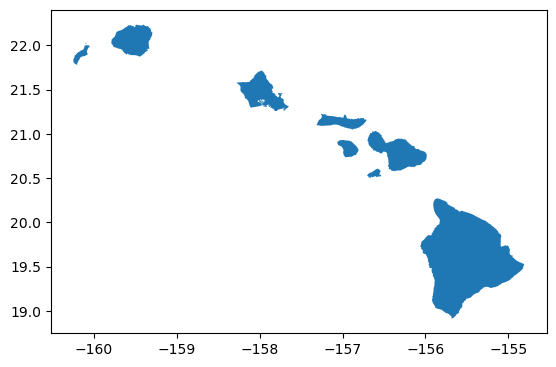

In [32]:
hawaii_gdf = gdf[gdf.STATE=='HI']
hawaii_gdf = hawaii_gdf.merge(df_diff, on="STATE")
hawaii_gdf
hawaii_gdf.plot()

Removing Alaska and Hawaii from the table due to mapping errors. Will add back later separately.

In [33]:
gdf_map = gdf.drop(gdf[gdf['STATE'] == 'AK'].index)
gdf_map = gdf_map.drop(gdf_map[gdf_map['STATE'] == 'HI'].index)
len(gdf_map)

49

In [34]:
gdf_new = gdf_map.merge(df_diff, on="STATE")
gdf_new.head()

,STATE,NAME,FIPS,LON,LAT,geometry,BA_2005,BA_2022
0,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ...",31078,70750
1,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499...",19133,37562
2,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.49090 37.00361, -110.48750 37.0...",56547,115080
3,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263...",271636,485954
4,CO,Colorado,08,-105.54783,38.99855,"POLYGON ((-106.87560 41.00301, -106.85850 41.0...",55916,115689


In [35]:
alaska_gdf

,STATE,NAME,FIPS,LON,LAT,geometry,BA_2005,BA_2022
0,AK,Alaska,02,-152.255721,64.242373,"MULTIPOLYGON (((-169.16139 52.79556, -169.1610...",4730,8456


In [36]:
print(gdf_new['BA_2022'].max())
print(gdf_new['BA_2005'].max())

607279
281702


Plotting the values on a geographical map we get a heatmap:

<Axes: >

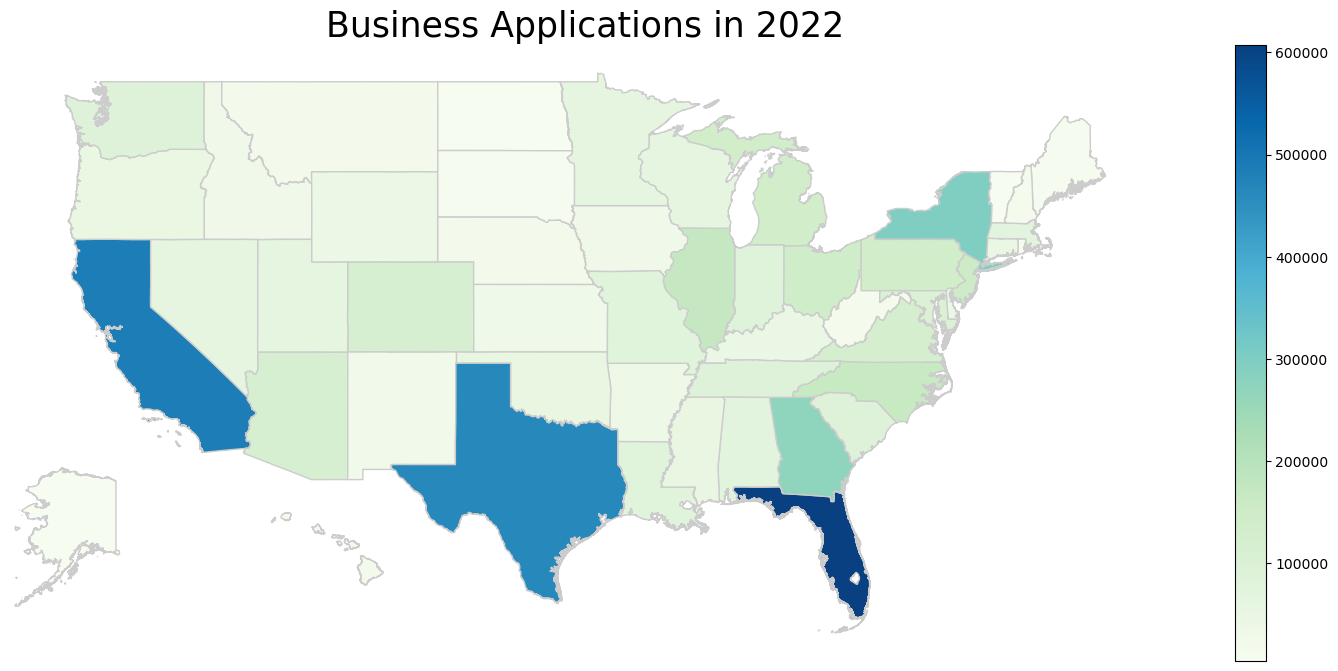

In [37]:
# Print the map for 2022
# Set the range for the choropleth
title = 'Business Applications in 2022'
col = 'BA_2022'
vmin = gdf_new['BA_2005'].min()
vmax = gdf_new['BA_2022'].max()
cmap = 'GnBu'
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))
# Remove the axis
ax.axis('off')
gdf_new.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap, legend=True, vmin = vmin, vmax=vmax)
# Add a title
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})
# Create an annotation for the data source

#Add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
alaska_gdf.plot(column=alaska_gdf[col], cmap="GnBu", ax=akax, linewidth=1, edgecolor='0.8', vmin = vmin, vmax=vmax)

#Add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])      
hiax.axis('off')
hawaii_gdf.plot(column=hawaii_gdf[col], cmap="GnBu", ax=hiax, linewidth=1, edgecolor='0.8', vmin = vmin, vmax=vmax)



findfont: Font family 'Calibri Light' not found.
findfont: Font family 'Calibri Light' not found.
findfont: Font family 'Calibri Light' not found.
findfont: Font family 'Calibri Light' not found.


<Axes: >

findfont: Font family 'Calibri Light' not found.
findfont: Font family 'Calibri Light' not found.
findfont: Font family 'Calibri Light' not found.


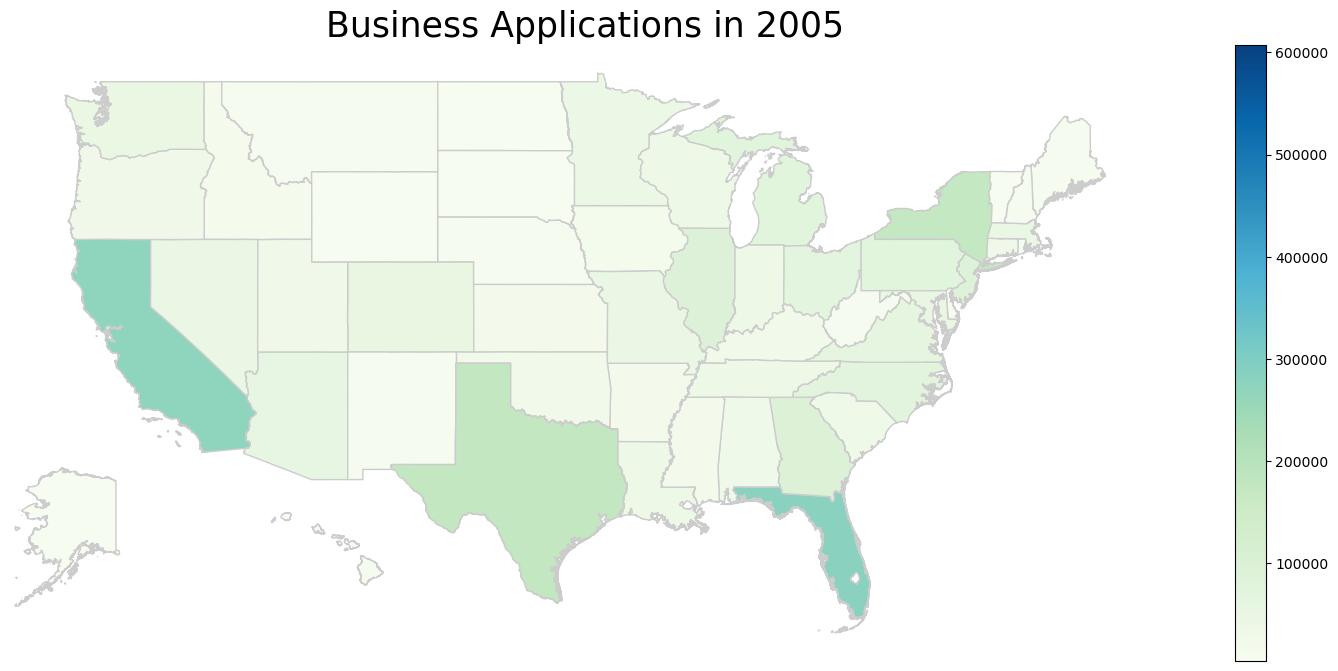

In [38]:
# Print the map for 2005
# Set the range for the choropleth
title = 'Business Applications in 2005'
col = 'BA_2005'
vmin = gdf_new['BA_2005'].min()
vmax = gdf_new['BA_2022'].max()
cmap = 'GnBu'
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))
# Remove the axis
ax.axis('off')
gdf_new.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap, legend=True, vmin = vmin, vmax=vmax)
# Add a title
ax.set_title(title, fontdict={'fontname': 'Calibri Light','fontsize': '25', 'fontweight': '3'})
# Create an annotation for the data source

#Add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
alaska_gdf.plot(column=alaska_gdf[col], cmap="GnBu", ax=akax, linewidth=1, edgecolor='0.8', vmin = vmin, vmax=vmax)

#Add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])      
hiax.axis('off')
hawaii_gdf.plot(column=hawaii_gdf[col], cmap="GnBu", ax=hiax, linewidth=1, edgecolor='0.8', vmin = vmin, vmax=vmax)



## Trends

### Importing the data used to create charts 

Using the combined.csv from data cleaning to get consolidated information

In [39]:
combined_data_new = pd.read_csv("combined.csv")
combined_data_new.head()

,State,year,tax_rate,gdp,min_wage,unemployment_rate,population,median_hh_income,business_applications
0,Alabama,2005,6.5,1.588500e+11,5.15,4.5,4569805,53550,31078
1,Alabama,2006,6.5,1.664700e+11,5.15,4.0,4628981,53170,33918
2,Alabama,2007,6.5,1.729800e+11,5.15,4.0,4672840,57660,33701
3,Alabama,2008,6.5,1.745300e+11,6.55,5.7,4718206,58600,32222
4,Alabama,2009,6.5,1.709300e+11,7.25,11.0,4757938,52890,29221


Taking top 5 states with the largest number of business applications in 2022

In [40]:
select_df = combined_data_new[combined_data_new['year'] == 2022].reset_index(drop=True)
select_df = select_df.sort_values(by=['business_applications'])
select_df = select_df.tail()
selected_states = select_df['State'].tolist()
selected_states

['Georgia', 'New York', 'Texas', 'California', 'Florida']

In [41]:
col_list = list(select_df.columns)

del col_list[0] #deleting 'State'
del col_list[0] #deleting 'year'

print(col_list)

['tax_rate', 'gdp', 'min_wage', 'unemployment_rate', 'population', 'median_hh_income', 'business_applications']


Mapping the trends for the top 5 states

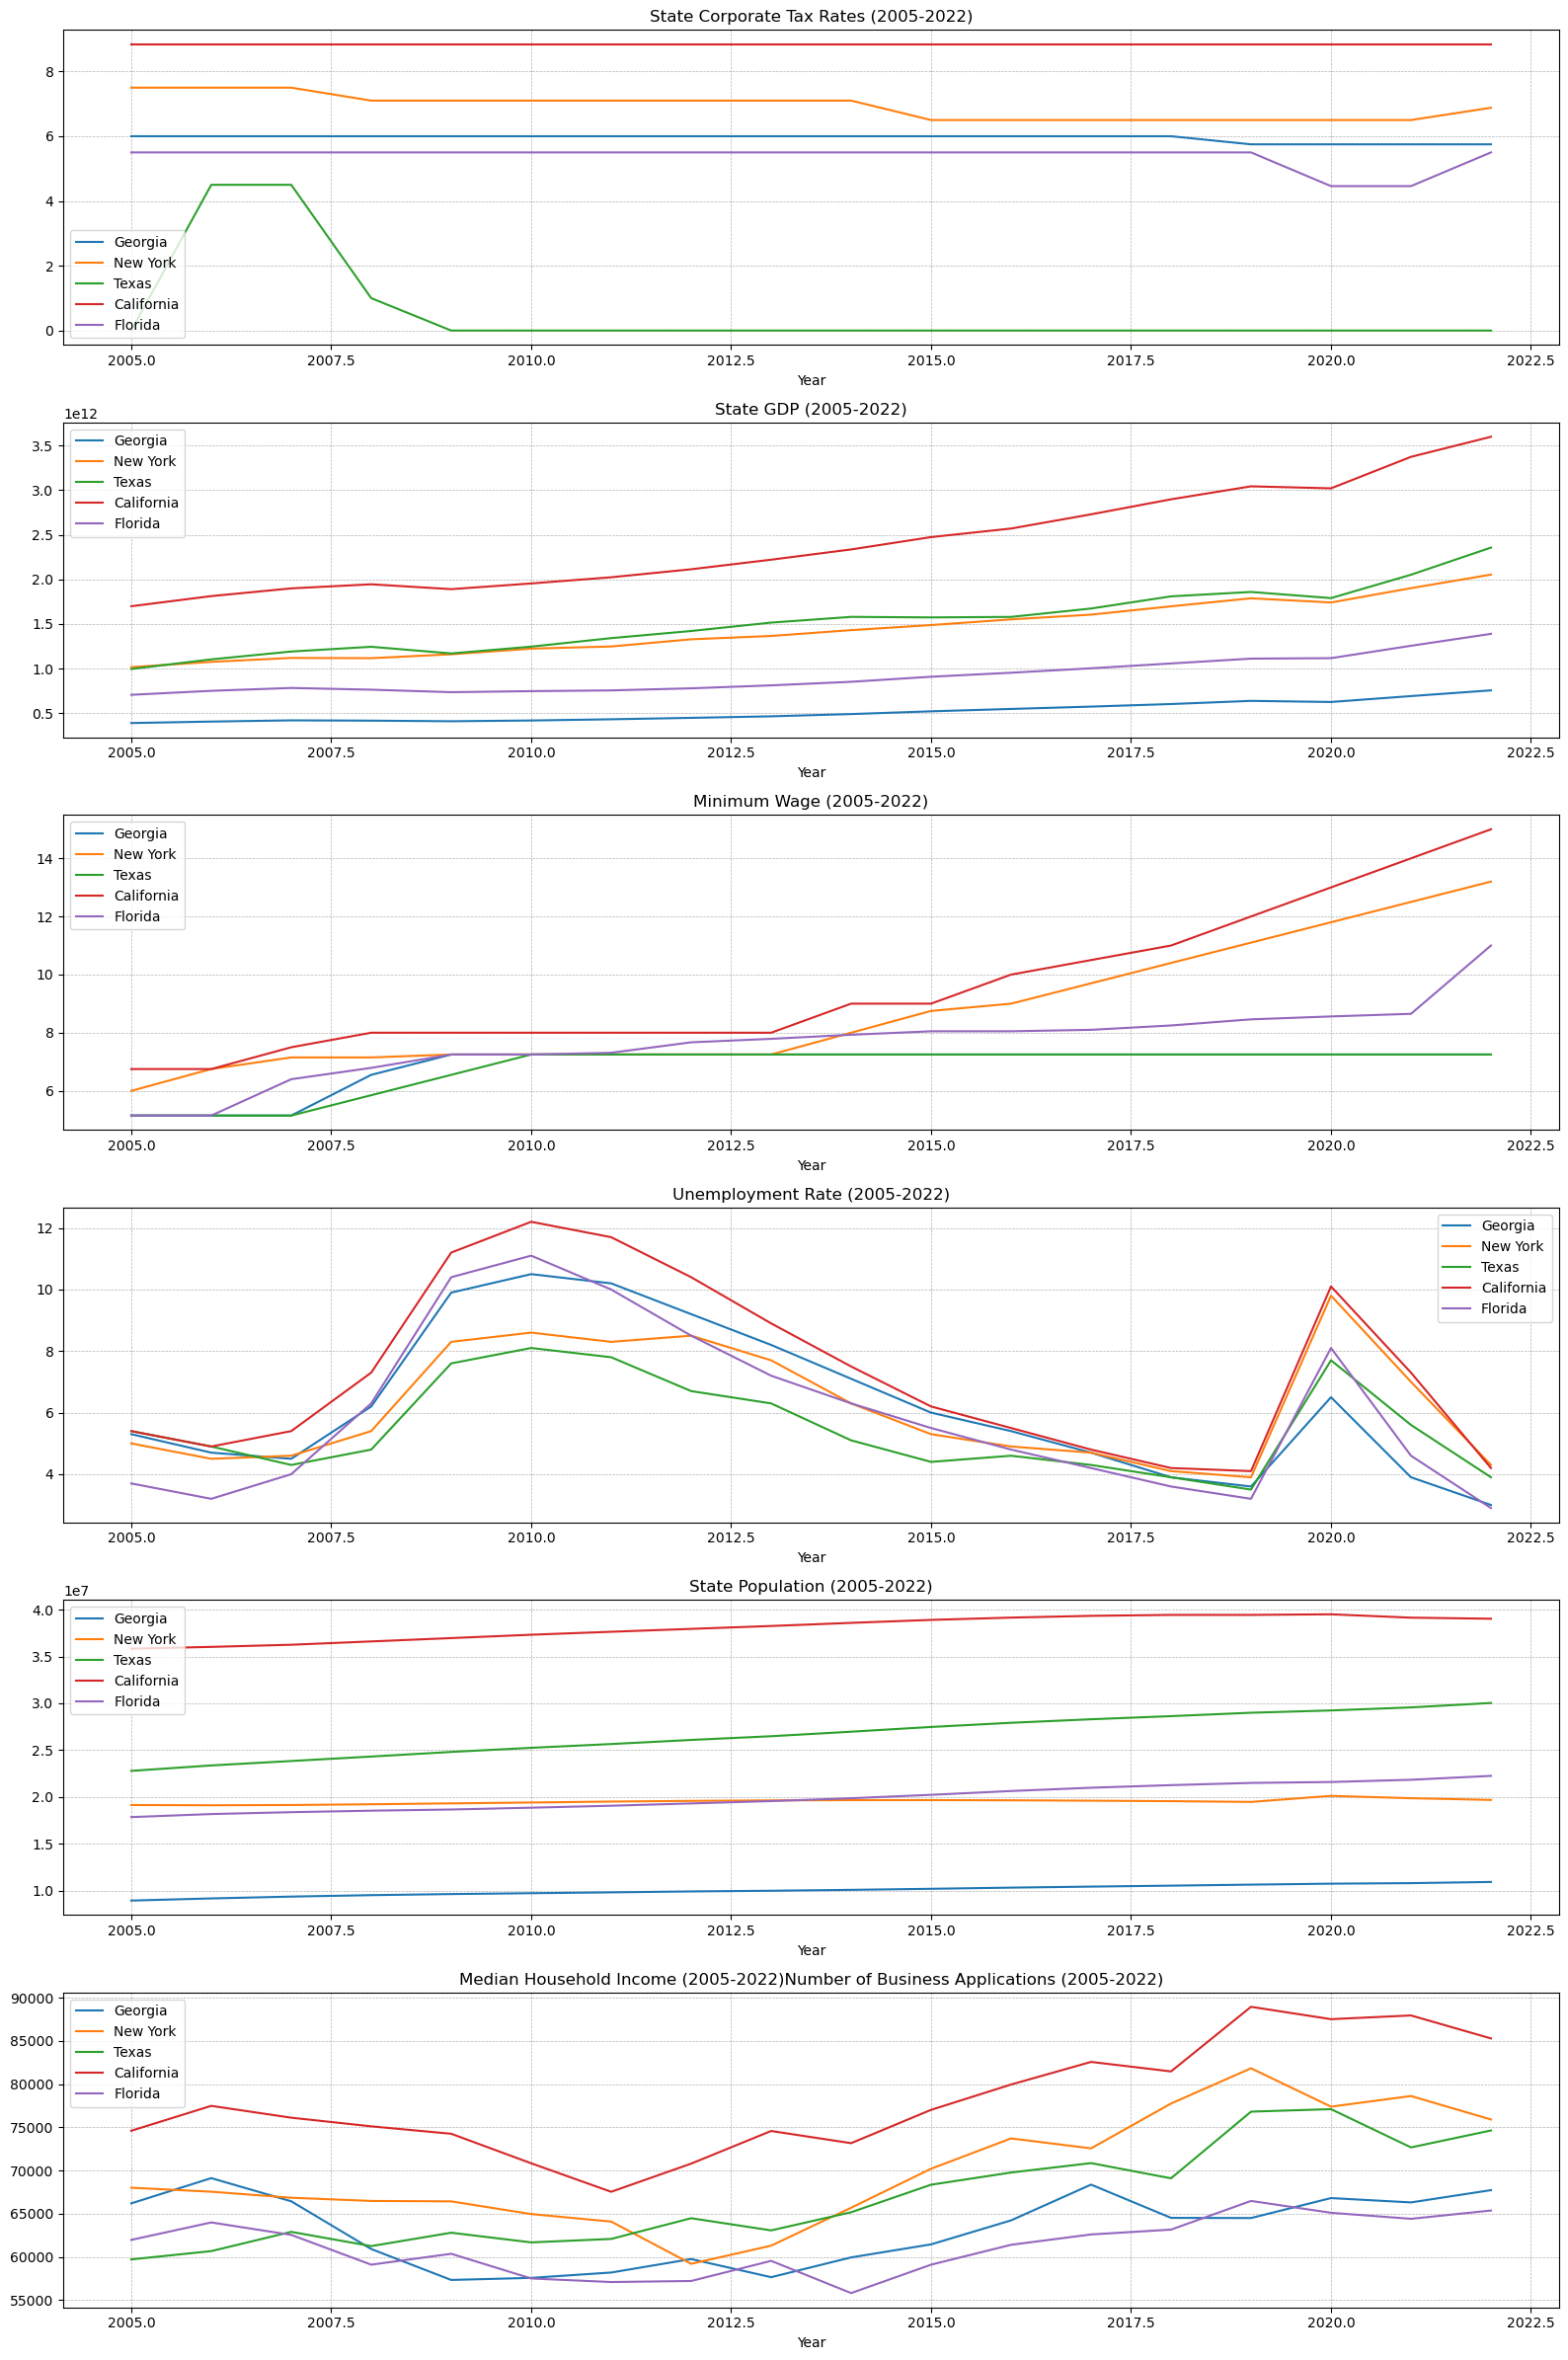

In [42]:
# Setting up a multi-plot grid for visualization
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(16, 24))

# Time Series Plot for the selected variables
titles = [
    'State Corporate Tax Rates (2005-2022)', 
    'State GDP (2005-2022)', 
    'Minimum Wage (2005-2022)', 
    'Unemployment Rate (2005-2022)', 
    'State Population (2005-2022)', 
    'Median Household Income (2005-2022)'
    'Number of Business Applications (2005-2022)'
]

for idx, (var, title) in enumerate(zip(col_list, titles)):
    for state in selected_states:
        state_data = combined_data_new[combined_data_new['State'] == state]
        axes[idx].plot(state_data['year'], state_data[var], label=state)
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Year')
    axes[idx].legend()
    axes[idx].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


Here are the trends from for the selected states: California, Texas, Florida, New York, and Georgia for the given years 2005 to 2022 

- Trend in GDP: Most states show a general positive trend in GDP, with some fluctuations such as the financial crisis of 2008 and the COVID pandemic in 2020. Texas and California, in particular, have a notable increase in GDP over the years.
- Trend in Business Applications: We observe spikes in business applications around 2020 for most states. According to the University of Maryland, there was a surge in Americans starting businesses during and after the pandemic. The new companies range from restaurants and dry cleaners to high-tech start-ups. (source: https://www.nytimes.com/2023/09/29/us/politics/pandemic-economy-surge-start-ups.html) 
- Trend in Minimum Wage: There's an upward trend in minimum wage for all states.
- Trend in Unemployment Rate: There are fluctuations in the unemployment rate, with spikes observed around the financial crisis of 2008 and the COVID pandemic in 2020.
- Trend in Population: The population generally grows over time, with Texas and Florida showing significant growth.
- Trend in Median Household Income: There's an upward trend in median household income for all states.


##  Number of Business Applications over time for 5 states with change in tax rate

In [43]:
biz_apps_highest = df_biz.nlargest(5,"2022")
biz_apps_highest = df_biz.set_index('Name')
biz_apps_highest = biz_apps_highest.drop(columns=['STATE'])
biz_apps_highest.head()

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Name,,,,,,,,,,,,,,,,,,
Alabama,31078,33918,33701,32222,29221,29916,28994,29694,29331,29574,31506,34286,36760,41948,41478,58557,75443,70750
Alaska,4730,5229,5138,4979,4396,4661,5083,5210,5383,5447,5901,6358,7263,9238,8118,8063,8063,8456
Arizona,56547,63067,64673,62972,58279,57926,57837,55305,55516,56401,57176,61448,67833,73424,76539,89957,113142,115080
Arkansas,19133,20400,19630,18707,17927,17843,17939,17812,17551,18445,19033,20445,23135,25678,25473,32314,41599,37562
California,271636,286652,286737,271606,249246,256436,270057,268103,278014,293443,303657,312636,326592,364807,364924,438554,519236,485954


### Florida

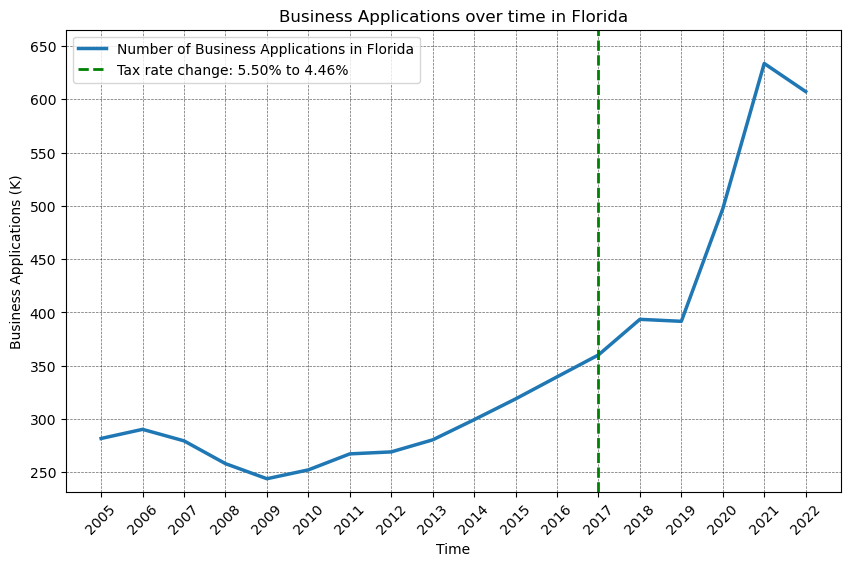

In [44]:
fl_plot = biz_apps_highest.loc['Florida', '2005':'2022'].plot(kind='line', figsize=(10, 6), lw=2.5, label = "Number of Business Applications in Florida")

# Setting labels and title
fl_plot.set_ylabel('Business Applications (K)')
fl_plot.set_xlabel('Time')
fl_plot.set_title('Business Applications over time in Florida')
plt.xticks(rotation=45) # Rotate years for better readability

# Adding vertical lines for 2019 and 2020
fl_plot.axvline(x=biz_apps_highest.columns.get_loc('2019') - 2, color='green', linestyle='--', linewidth=2,
                label="Tax rate change: 5.50% to 4.46%")

#plt.xticks(ticks=range(len(fl_plot.index)), labels=fl_data.index, rotation=45)  # Display every year on x-axis
plt.xticks(ticks=range(len(biz_apps_highest.columns)), labels=biz_apps_highest.columns, rotation=45)


# Change absolute number of business applications by giving it in thousands
fl_plot.set_yticks(fl_plot.get_yticks())
fl_plot.set_yticklabels([int(y/1000) for y in fl_plot.get_yticks()])

# Change y-axis limit using 5% buffer 
buffer = 0.05  
fl_min = biz_apps_highest.loc['Florida', '2005':'2022'].min()
fl_max = biz_apps_highest.loc['Florida', '2005':'2022'].max()
fl_plot.set_ylim(fl_min - buffer * fl_min, fl_max + buffer * fl_max)

# Implement gridlines
fl_plot.grid(True, which='both', linestyle='--', linewidth=0.5, color='black', alpha=0.6)

# Showing the legend and the plot
fl_plot.legend()
plt.show()

### California

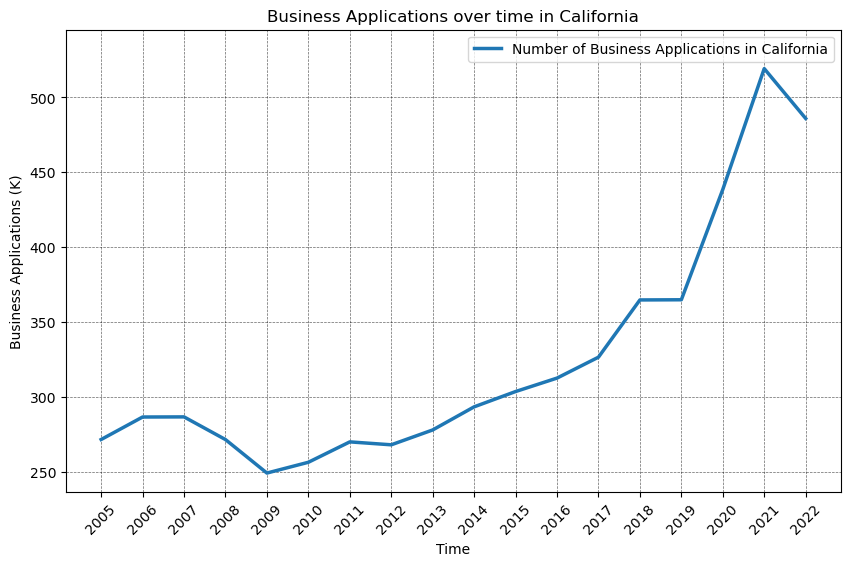

In [45]:
ca_plot = biz_apps_highest.loc['California', '2005':'2022'].plot(kind='line', figsize=(10, 6), lw=2.5, label = "Number of Business Applications in California")

# Setting labels and title
ca_plot.set_ylabel('Business Applications (K)')
ca_plot.set_xlabel('Time')
ca_plot.set_title('Business Applications over time in California')
plt.xticks(rotation=45) # Rotate years for better readability

# Set x-axis to include every year in the data
plt.xticks(ticks=range(len(biz_apps_highest.columns)), labels=biz_apps_highest.columns, rotation=45)

# Change absolute number of business applications by giving it in thousands
ca_plot.set_yticks(ca_plot.get_yticks())
ca_plot.set_yticklabels([int(y/1000) for y in ca_plot.get_yticks()])

# Change y-axis limit using buffer 
buffer = 0.05 
ca_min = biz_apps_highest.loc['California', '2005':'2022'].min()
ca_max = biz_apps_highest.loc['California', '2005':'2022'].max()
ca_plot.set_ylim(ca_min - buffer * ca_min, ca_max + buffer * ca_max)

# Implement gridlines
ca_plot.grid(True, which='both', linestyle='--', linewidth=0.5, color='black', alpha=0.6)

# Showing the legend and the plot
ca_plot.legend()
plt.show()


### Texas

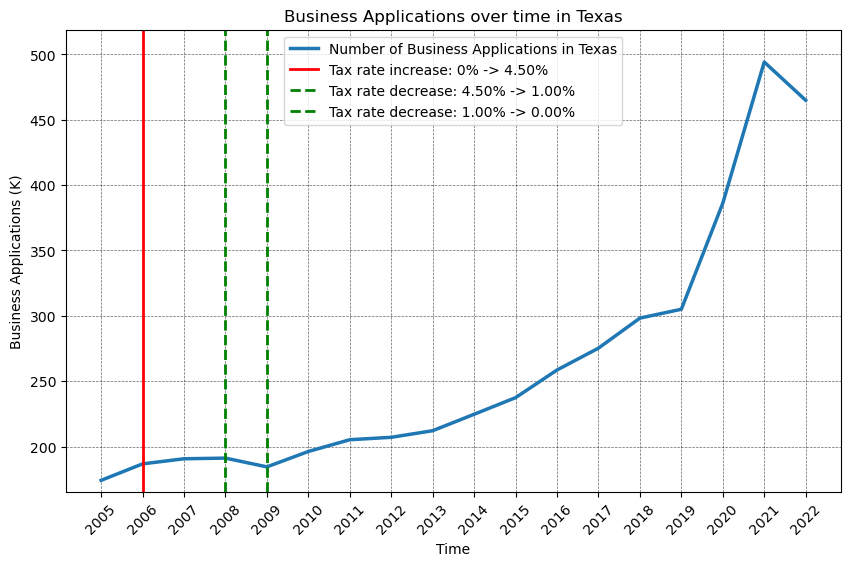

In [46]:
tx_plot = biz_apps_highest.loc['Texas', '2005':'2022'].plot(kind='line', figsize=(10, 6), lw=2.5, label = "Number of Business Applications in Texas")

# Setting labels and title
tx_plot.set_ylabel('Business Applications (K)')
tx_plot.set_xlabel('Time')
tx_plot.set_title('Business Applications over time in Texas')

# Set xticks to every year in the data
plt.xticks(ticks=range(len(biz_apps_highest.columns)), labels=biz_apps_highest.columns, rotation=45)

# Adding vertical lines for 2006, 2008, and 2009 indicating tax rate change
tx_plot.axvline(x = biz_apps_highest.columns.get_loc('2006'), color='red', linestyle='-', linewidth=2, label='Tax rate increase: 0% -> 4.50%')
tx_plot.axvline(x = biz_apps_highest.columns.get_loc('2008'), color='green', linestyle='--', linewidth=2, label='Tax rate decrease: 4.50% -> 1.00%')
tx_plot.axvline(x = biz_apps_highest.columns.get_loc('2009'), color='green', linestyle='--', linewidth=2, label='Tax rate decrease: 1.00% -> 0.00%')

# Change absolute number of business applications by giving it in thousands
tx_plot.set_yticks(tx_plot.get_yticks())
tx_plot.set_yticklabels([int(y/1000) for y in tx_plot.get_yticks()])

# Change y-axis limit using buffer 
buffer = 0.05 
tx_min = biz_apps_highest.loc['Texas'].min()
tx_max = biz_apps_highest.loc['Texas'].max()
tx_plot.set_ylim(tx_min - buffer * tx_min, tx_max + buffer * tx_max)

# Implement gridlines
tx_plot.grid(True, which='both', linestyle='--', linewidth=0.5, color='black', alpha=0.6)

# Showing the legend and the plot
tx_plot.legend()
plt.show()

### New York

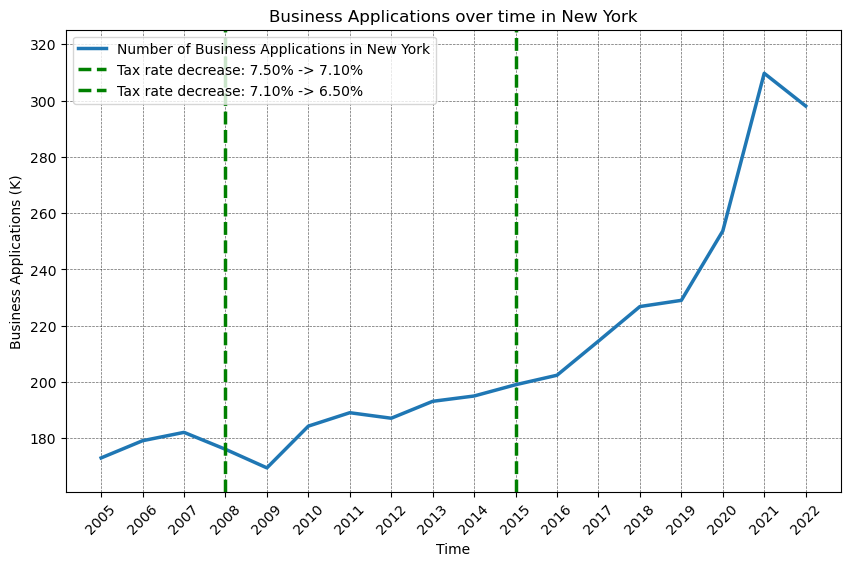

In [47]:
ny_plot = biz_apps_highest.loc['New York', '2005':'2022'].plot(kind='line', figsize=(10, 6), lw=2.5, label = "Number of Business Applications in New York")

# Setting labels and title
ny_plot.set_ylabel('Business Applications (K)')
ny_plot.set_xlabel('Time')
ny_plot.set_title('Business Applications over time in New York')

# Set x-axis to every year in the data
plt.xticks(ticks=range(len(biz_apps_highest.columns)), labels=biz_apps_highest.columns, rotation=45)

# Adding vertical lines for 2019 and 2020 indicating tax rate change
ny_plot.axvline(x = biz_apps_highest.columns.get_loc('2008'), color='green', linestyle='--', linewidth=2.5, label='Tax rate decrease: 7.50% -> 7.10%')
ny_plot.axvline(x = biz_apps_highest.columns.get_loc('2015'), color='green', linestyle='--', linewidth=2.5, label='Tax rate decrease: 7.10% -> 6.50%')

# Change absolute number of business applications by giving it in thousands
ny_plot.set_yticks(ny_plot.get_yticks())
ny_plot.set_yticklabels([int(y/1000) for y in ny_plot.get_yticks()])

# Change upper limit of y-axis using buffer
buffer = 0.05  # 5% buffer
ny_min = biz_apps_highest.loc['New York'].min()
ny_max = biz_apps_highest.loc['New York'].max()
ny_plot.set_ylim(ny_min - buffer * ny_min, ny_max + buffer * ny_max)


# Introudce gridlines
ny_plot.grid(True, which='both', linestyle='--', linewidth=0.5, color='black', alpha=0.6)

# Showing the legend and the plot
ny_plot.legend()
plt.show()


### Georgia

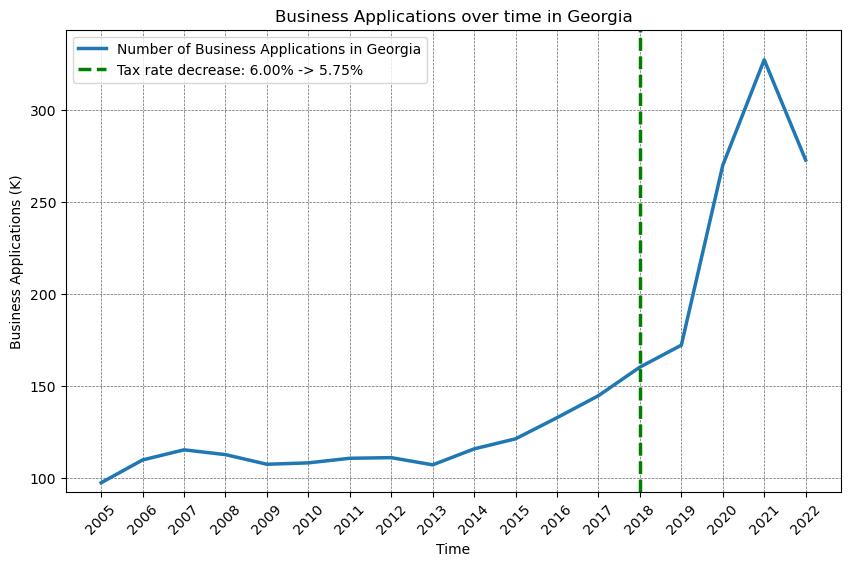

In [48]:
# Plotting the data
ga_plot = biz_apps_highest.loc['Georgia', '2005':'2022'].plot(kind='line', figsize=(10, 6), lw=2.5, label = "Number of Business Applications in Georgia")

# Setting labels and title
ga_plot.set_ylabel('Business Applications (K)')
ga_plot.set_xlabel('Time')
ga_plot.set_title('Business Applications over time in Georgia')

# Set xticks to every year in the data
plt.xticks(ticks=range(len(biz_apps_highest.columns)), labels=biz_apps_highest.columns, rotation=45)

# Adding vertical lines for 2018 indicating decrease in tax rate
ga_plot.axvline(x = biz_apps_highest.columns.get_loc('2018'), color='green', linestyle='--', linewidth=2.5, label='Tax rate decrease: 6.00% -> 5.75%')

# Change absolute number of business applications by giving it in thousands
ga_plot.set_yticks(ga_plot.get_yticks())
ga_plot.set_yticklabels([int(y/1000) for y in ga_plot.get_yticks()])

# Change upper limit of y-axis using buffer
buffer = 0.05 
ga_min = biz_apps_highest.loc['Georgia'].min()
ga_max = biz_apps_highest.loc['Georgia'].max()
ga_plot.set_ylim(ga_min - buffer * ga_min, ga_max + buffer * ga_max)

# Introudce gridlines
ga_plot.grid(True, which='both', linestyle='--', linewidth=0.5, color='black', alpha=0.6)

# Showing the legend and the plot
ga_plot.legend()
plt.show()

# State-to-State Migration Network

In [49]:
import pandas as pd

df_2005 = pd.read_excel("data/State-to-state_mig.xlsx", sheet_name="2005")
df_2005.head()

,Unnamed: 0,Alabama,Unnamed: 2,Alaska,Unnamed: 4,Arizona,Unnamed: 6,Arkansas,Unnamed: 8,California,...,Virginia,Unnamed: 96,Washington,Unnamed: 98,West Virginia,Unnamed: 100,Wisconsin,Unnamed: 102,Wyoming,Unnamed: 104
0,NaN,Estimate,MOE,Estimate,MOE,Estimate,MOE,Estimate,MOE,Estimate,...,Estimate,MOE,Estimate,MOE,Estimate,MOE,Estimate,MOE,Estimate,MOE
1,Alabama,580353,22382,608,432,574,542,3168,1655,3025,...,2572,1142,1324,817,432,467,303,230,436,507
2,Alaska,152,176,84150,6528,883,530,54,83,3898,...,618,537,5711,2516,0,233,765,465,222,353
3,Arizona,1427,784,1836,1443,917186,26917,1845,948,94296,...,4196,2459,10335,2314,527,468,7798,2272,1458,811
4,Arkansas,1894,1228,660,504,1266,617,390364,17198,6167,...,1355,997,1062,1260,59,77,1542,1232,41,71


In [50]:
states_of_interest = ['California', 'Florida', 'New York', 'Georgia', 'Texas']

year_groups = {
    "2005-2008": ["2005", "2006", "2007", "2008"],
    "2009-2012": ["2009", "2010", "2011", "2012"],
    "2013-2016": ["2013", "2014", "2015", "2016"],
    "2017-2018": ["2017", "2018"],
    "2019-2022": ["2019", "2021", "2022"]
}

# construct a dictionary with key = period and value = squared matrix 
aggregated_data = {}

for group, years in year_groups.items():
    aggregated_df = pd.DataFrame(0, index=states_of_interest, columns=states_of_interest)
    for year in years:
        df = pd.read_excel("data/State-to-state_mig.xlsx", sheet_name=year)
        migration_data = df.set_index("Unnamed: 0").loc[states_of_interest, states_of_interest]
        aggregated_df += migration_data
    aggregated_data[group] = aggregated_df


aggregated_data["2019-2022"]

,California,Florida,New York,Georgia,Texas
California,NaN,75941,101545,34609,112919
Florida,116793,NaN,240447,134394,92624
New York,90348,64720,NaN,22169,42084
Georgia,70305,146778,45214,NaN,67619
Texas,292223,114008,73919,63314,NaN


In [51]:
# Ensure that the diagonal values (self-connections) are set to 0
for group, data in aggregated_data.items():
    for state in states_of_interest:
        data.at[state, state] = 0

aggregated_data["2009-2012"]

,California,Florida,New York,Georgia,Texas
California,0,82229,103954,43732,151778
Florida,87149,0,220790,150862,97815
New York,98477,118164,0,34027,40323
Georgia,55012,178607,53446,0,59748
Texas,251923,131854,76026,73823,0


/var/folders/hp/hkpqf03x0qdg7_8s3s9sy7gw0000gn/T/ipykernel_80865/1909894987.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', shrink=0.7, pad=0.05)


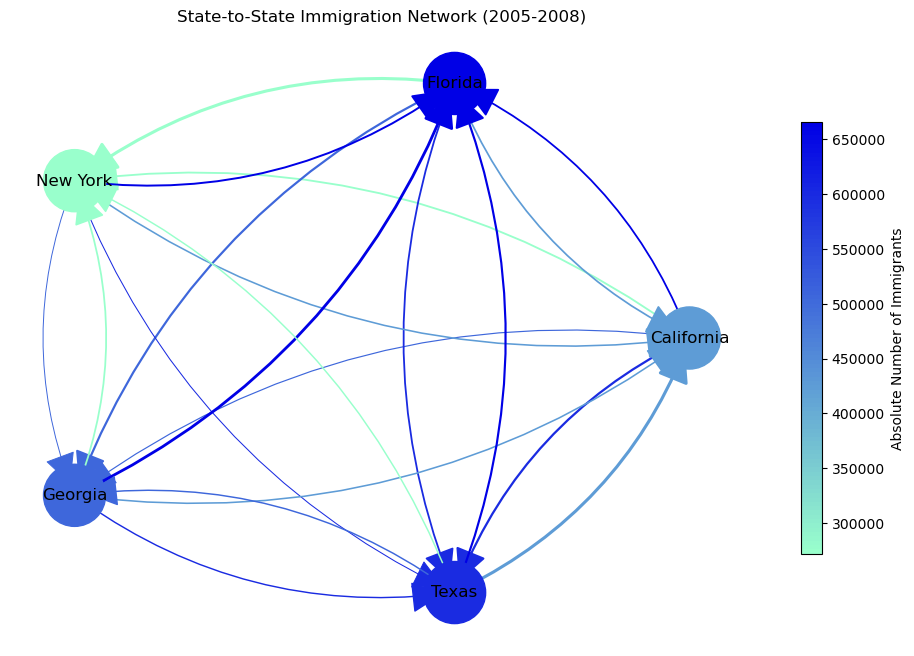

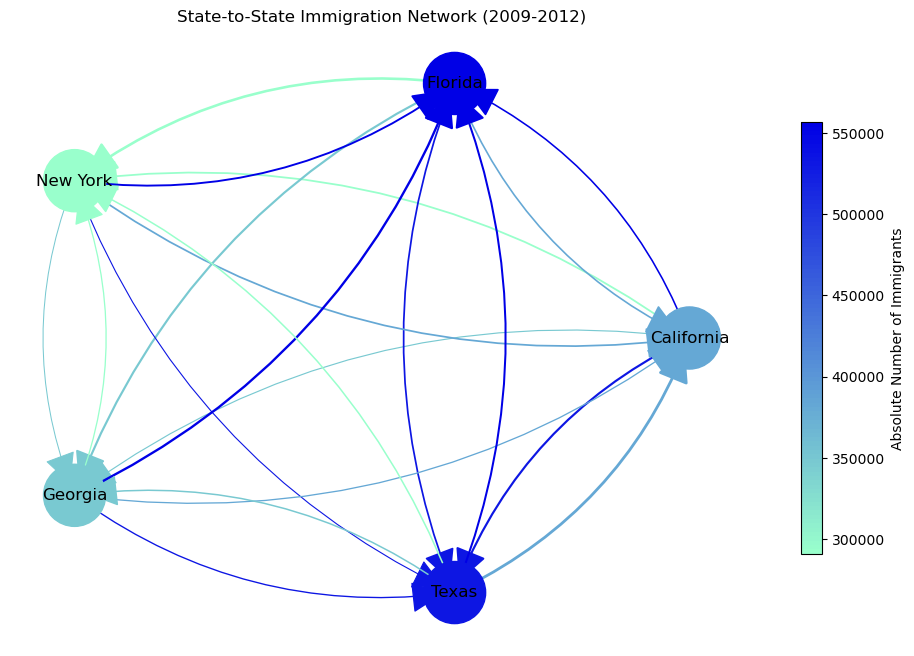

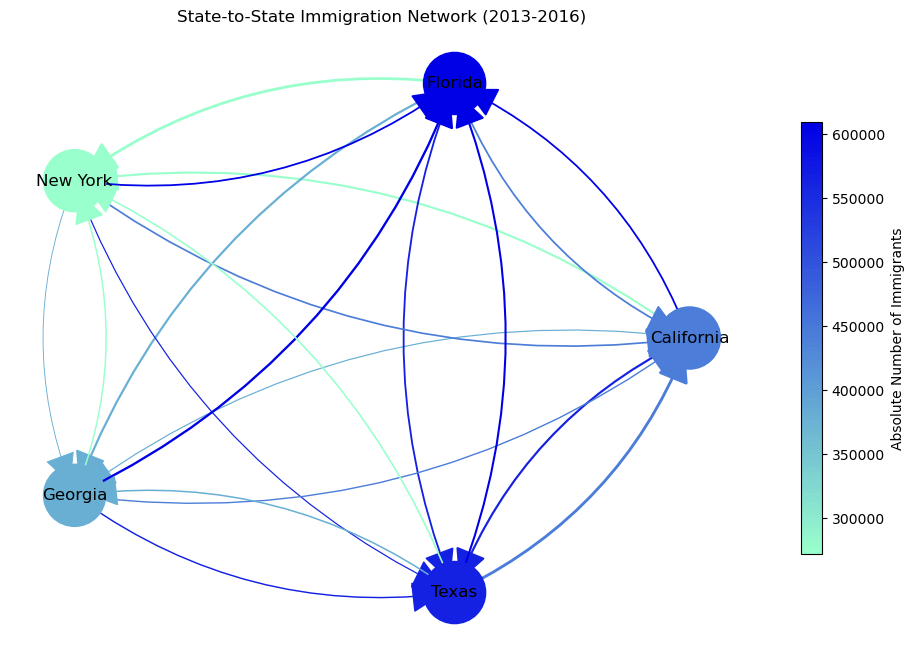

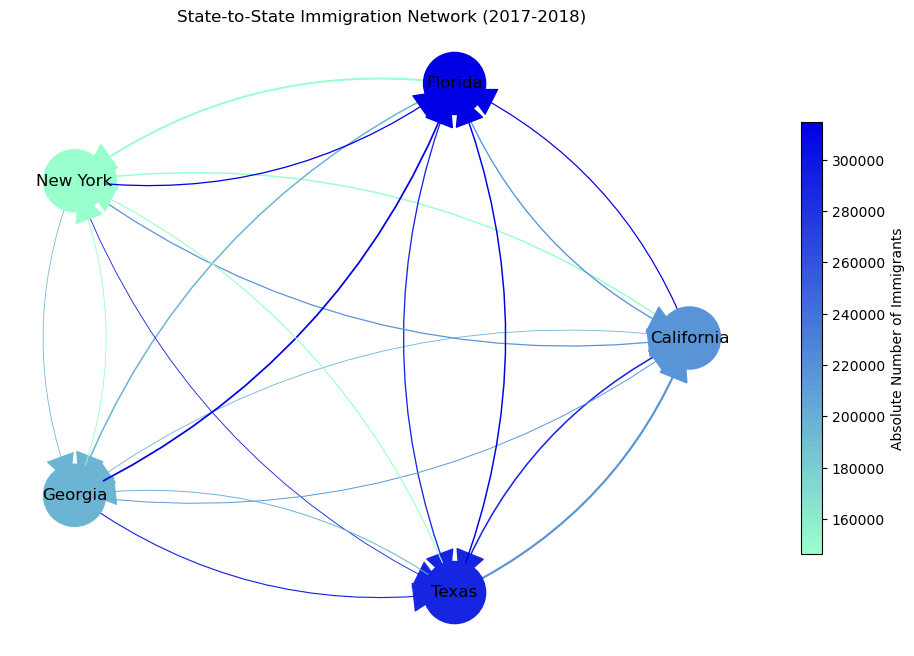

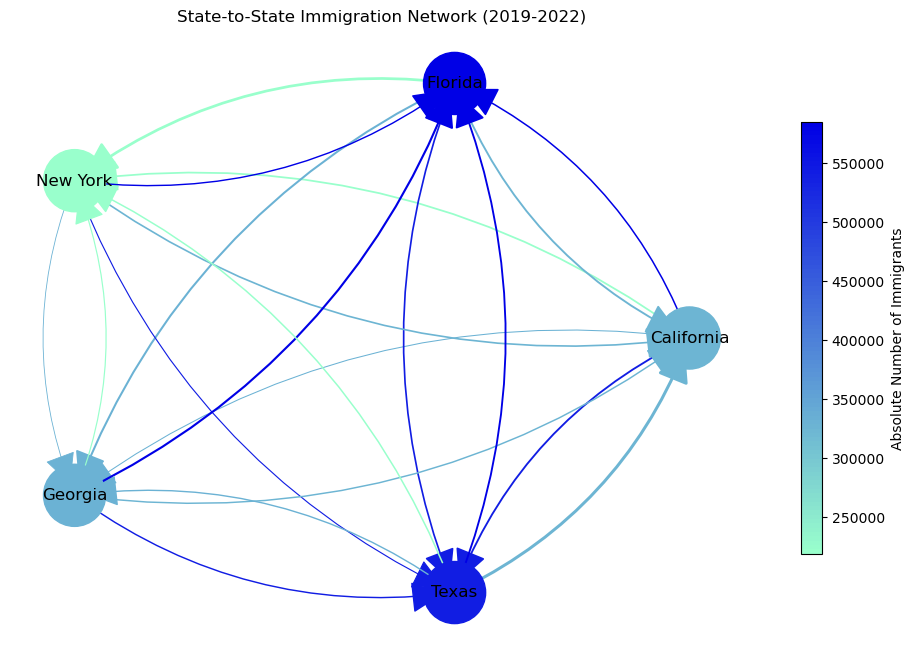

In [54]:
def plot_gradient_colored_network_with_legend(data, title):
    G = nx.DiGraph()

    # Add nodes
    for state in states_of_interest:
        G.add_node(state)

    # Add weighted edges
    for origin, row in data.iterrows():
        for destination, value in row.items():
            if origin != destination and value != 0:  # Ensure we don't add self-loops
                G.add_edge(origin, destination, weight=value)

    incoming_weights = {node: sum([data[neighbor][node] for neighbor in states_of_interest]) for node in G.nodes()}
    min_weight = min(incoming_weights.values())
    max_weight = max(incoming_weights.values())

    def gradient_colormap(value):
        # Color computation based on the given gradient
        return ((1 - value) * np.array([0.6, 1, 0.8]) + value * np.array([0, 0, 0.9]))

    node_colors = [gradient_colormap((incoming_weights[node] - min_weight) / (max_weight - min_weight)) for node in G.nodes()]

    pos = nx.circular_layout(G)
    plt.figure(figsize=(12, 8))
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors)
    nx.draw_networkx_labels(G, pos)
    
    edge_widths = [np.sqrt(G[u][v]['weight']) / 250 for u, v in G.edges()]
    edge_colors = [gradient_colormap((incoming_weights[v] - min_weight) / (max_weight - min_weight)) for u, v in G.edges()]
    
    nx.draw_networkx_edges(
        G, pos, edgelist=G.edges(), edge_color=edge_colors, width=edge_widths, 
        arrowstyle='-|>', arrowsize=50, connectionstyle="arc3,rad=0.2"
    )
    
    # Adding the custom colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap=mpl.colors.ListedColormap([gradient_colormap(i) for i in np.linspace(0, 1, 100)]), 
                               norm=Normalize(vmin=min_weight, vmax=max_weight))
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='vertical', shrink=0.7, pad=0.05)
    cbar.set_label('Absolute Number of Immigrants', rotation=90)

    plt.title(title)
    plt.axis('off')
    plt.show()


# Visualize all the time periods
for period, data in aggregated_data.items():
    plot_gradient_colored_network_with_legend(data, f"State-to-State Immigration Network ({period})")